In [1]:
#neutrino signal in SABRE South Veto detector, calculation based on https://arxiv.org/pdf/1712.06985.pdf and https://arxiv.org/pdf/1605.07803.pdf
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
%matplotlib inline

from snvmodels.neutrino import Neutrino
from snvmodels.solarndists import SolarNDist
from constants import *
import sympy
import scipy
from scipy.signal import gaussian, convolve

x = sympy.symbols('x')

In [2]:
Model = Neutrino()

In [3]:
## Supernova neutrino flux
Ev = np.logspace(-2,3,501) # Supernova neutrino energy, units of [MeV]
Ev_eV=Ev*MeV

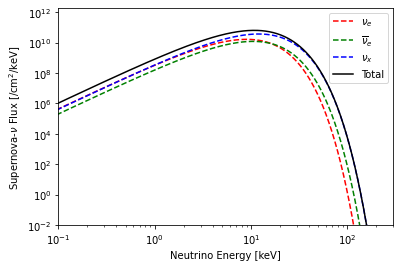

In [4]:
flux_electron_nu = Model.Flux_neutrino(Ev_eV,'supernova_e',1,12*MeV,3,1)*MeV #[/cm2/keV]
plt.plot(Ev, flux_electron_nu, label=r'$\nu_{e}$', color = 'r', linestyle='--')
flux_electron_antinu = Model.Flux_neutrino(Ev_eV,'supernova_ea', 1,14*MeV,3,1)*MeV #[/cm2/keV]
plt.plot(Ev, flux_electron_antinu , label=r'$\overline{\nu}_e$', color = 'g', linestyle='--')
flux_x_nu = Model.Flux_neutrino(Ev_eV,'supernova_mu', 4,16*MeV,3,1)*MeV #[/cm2/keV]
plt.plot(Ev, flux_x_nu, label=r'$\nu_x$', color = 'b', linestyle='--')
flux_total=flux_electron_nu+flux_electron_antinu+flux_x_nu
plt.plot(Ev, flux_total, label=r'Total', color = 'black', linestyle='-')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-1,3e2)
plt.ylim(1e-2, 2e12)
plt.legend()
plt.xlabel(r"Neutrino Energy [keV]")
plt.ylabel(r"Supernova-$\nu$ Flux [/cm$^2$/keV]")
plt.savefig('fig/snv_flux.pdf',format='pdf')

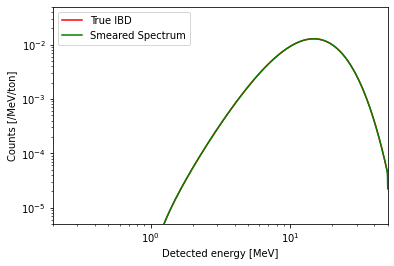

In [5]:
num=1000
Ed_IBD = np.linspace(0,50,num+1)[1:]# Nuclear recoil energy, units of keV
Ed_IBD_eV = Ed_IBD*MeV # Nuclear recoil energy, units of keV
rate_supernova_IBD=np.array([Model.dRdEd(Ev_eV,Edi,12*MeV,'IBD','supernova_e')*MeV for Edi in Ed_IBD_eV])
plt.plot(Ed_IBD, rate_supernova_IBD, label='True IBD',color='r')

#gaussian smearing
def g(x, mu, sig):
    return 1.0 / (np.sqrt(2.0 * np.pi) * sig) * np.exp(-np.power((x - mu) / sig, 2.0) / 2)
smeared_IBD=np.zeros(num)
for i in range(num):
    t =np.arange(i-num+1,i+1)
    smeared_IBD[i]= -np.trapz(rate_supernova_IBD[i-t]*g(Ed_IBD[i]-Ed_IBD[i-t],0,0.03*np.sqrt(Ed_IBD[i-t])),Ed_IBD[i-t])
plt.plot(Ed_IBD, smeared_IBD, label='Smeared Spectrum',color='g')

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlim(0.2,50)
plt.ylim(5e-6, 5e-2)
plt.xlabel(r"Detected energy [MeV]")
plt.ylabel(r"Counts [/MeV/ton]")
plt.savefig('fig/IBD_rate.pdf',format='pdf')

In [6]:
print("Channel IBD: ")
print("Number of events for JUNO (20kt) with a threshold of 0.2 MeV: ", np.trapz(rate_supernova_IBD,Ed_IBD)*2e4)
print("Number of events for SABRE South (10t) with a threshold of 0.05 MeV: ", np.trapz(rate_supernova_IBD,Ed_IBD)*10)
print("Number of events for SABRE South (10t) with a threshold of 0.02 MeV: ", np.trapz(rate_supernova_IBD,Ed_IBD)*10)

Channel IBD: 
Number of events for JUNO (20kt) with a threshold of 0.2 MeV:  4355.633209201995
Number of events for SABRE South (10t) with a threshold of 0.05 MeV:  2.1778166046009977
Number of events for SABRE South (10t) with a threshold of 0.02 MeV:  2.1778166046009977


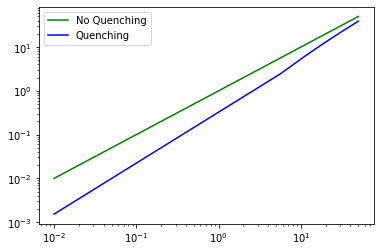

In [7]:
#define queching effect
#assuming LAB C6H5CnH2n+1, n=10
weight_H= 1*(2*10+6)/( 12*(6+10) + 1*(2*10+6))
weight_C12= 12*(6+10)/( 12*(6+10) + 1*(2*10+6))
density_LAB=0.863 
def quenching(T):
     eloss_file_H=np.loadtxt('snvmodels/p_in_H.dat',skiprows=8)
     eloss_file_C12=np.loadtxt('snvmodels/p_in_C12.dat',skiprows=8)
     eloss_file_energy=eloss_file_H[:,0]
     eloss_file_LAB = (weight_H*eloss_file_H[:,1]+weight_C12*eloss_file_C12[:,1])*density_LAB
     
     dx = 1e-4
     quenching=0
     while T > 0:
         yy = np.interp(T,eloss_file_energy,eloss_file_LAB,right=0)
         dE=yy*dx
         if T > dE:
             quenching += 1/(1+0.01*yy)*dE
             T=T-dE
         else:
             quenching += 1/(1+0.01*yy)*T
             break
     return quenching
T = np.linspace(0.01,50,10)

T_p = [quenching(i) for i in T]
plt.plot(T,T,'g',label=r'No Quenching')
plt.plot(T,T_p,'b',label=r'Quenching')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.savefig('fig/pES_quenching.pdf',format='pdf')

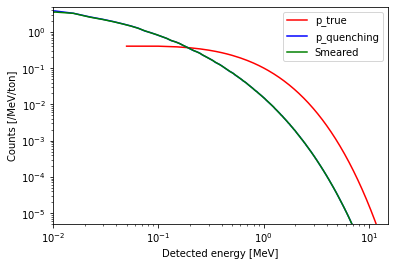

In [8]:
num=1000
Ed_pES = np.linspace(0,50,num+1)[1:]# Nuclear recoil energy, units of keV
Ed_pES_eV = Ed_pES*MeV # Nuclear recoil energy, units of keV
#true recoil energy spectrum
rate_supernova_pES=np.array([(Model.dRdEd(Ev_eV,Edi,12*MeV,'pES','supernova_e')+Model.dRdEd(Ev_eV,Edi,14*MeV,'pES','supernova_ea')+4*Model.dRdEd(Ev_eV,Edi,16*MeV,'pES','supernova_mu'))*MeV for Edi in Ed_pES_eV])
plt.plot(Ed_pES,rate_supernova_pES,label='p_true',color='r')


#queching effect
Ed_q=np.array([quenching(i) for i in Ed_pES])
dEddEd_q = np.gradient(Ed_pES)/np.gradient(Ed_q)
rate_supernova_pES_quenched=rate_supernova_pES*dEddEd_q
plt.plot(Ed_q,rate_supernova_pES_quenched,label='p_quenching',color='b')

#gaussian smearing
smeared_pES=np.zeros(num)
for i in range(num):
    t =np.arange(i-num+1,i+1)
    smeared_pES[i]= -np.trapz(rate_supernova_pES_quenched[i-t]*g(Ed_q[i]-Ed_q[i-t],0,0.03*np.sqrt(Ed_q[i-t])),Ed_q[i-t])
plt.plot(Ed_q, smeared_pES, label='Smeared',color='g')


plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlim(0.01,1.5e1)
plt.ylim(5e-6, 5)
plt.xlabel(r"Detected energy [MeV]")
plt.ylabel(r"Counts [/MeV/ton]")
plt.savefig('fig/pES_quenching_total.pdf',format='pdf')

Channel electron neutrino: 
Number of events for JUNO (20kt) with a threshold of 0.2 MeV:  88.77071738612361
Number of events for SABRE South (10t) with a threshold of 0.05 MeV:  0.16563658792010688
Number of events for SABRE South (10t) with a threshold of 0.02 MeV:  0.26740871998703725
Channel electron antineutrino: 
Number of events for JUNO (20kt) with a threshold of 0.2 MeV:  180.8138338281563
Number of events for SABRE South (10t) with a threshold of 0.05 MeV:  0.24854123344746015
Number of events for SABRE South (10t) with a threshold of 0.02 MeV:  0.3544136009673493
Channel x: 
Number of events for JUNO (20kt) with a threshold of 0.2 MeV:  1210.5120813067665
Number of events for SABRE South (10t) with a threshold of 0.05 MeV:  1.341505451669383
Number of events for SABRE South (10t) with a threshold of 0.02 MeV:  1.7590169353687368
Channel pES: 
Number of events for JUNO (20kt) with a threshold of 0.2 MeV:  1480.0966325210466
Number of events for SABRE South (10t) with a thresh

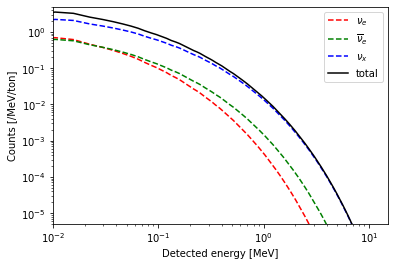

In [9]:
rate_supernova_pES_e=np.array([(Model.dRdEd(Ev_eV,Edi,12*MeV,'pES','supernova_e'))*MeV for Edi in Ed_pES_eV])
#queching effect
rate_supernova_pES_e_quenched=rate_supernova_pES_e*dEddEd_q
#gaussian smearing
smeared_pES_e=np.zeros(num)
for i in range(num):
    t =np.arange(i-num+1,i+1)
    smeared_pES_e[i]= -np.trapz(rate_supernova_pES_e_quenched[i-t]*g(Ed_q[i]-Ed_q[i-t],0,0.03*np.sqrt(Ed_q[i-t])),Ed_q[i-t])
plt.plot(Ed_q, smeared_pES_e, label=r'$\nu_{e}$',color='r', linestyle='--')
print("Channel electron neutrino: ")
print("Number of events for JUNO (20kt) with a threshold of 0.2 MeV: ", np.trapz(smeared_pES_e[Ed_q>0.2],Ed_q[Ed_q>0.2])*2e4)
print("Number of events for SABRE South (10t) with a threshold of 0.05 MeV: ", np.trapz(smeared_pES_e[Ed_q>0.05],Ed_q[Ed_q>0.05])*10)
print("Number of events for SABRE South (10t) with a threshold of 0.02 MeV: ", np.trapz(smeared_pES_e[Ed_q>0.02],Ed_q[Ed_q>0.02])*10)



rate_supernova_pES_ea=np.array([(Model.dRdEd(Ev_eV,Edi,14*MeV,'pES','supernova_ea'))*MeV for Edi in Ed_pES_eV])
#queching effect
rate_supernova_pES_ea_quenched=rate_supernova_pES_ea*dEddEd_q
#gaussian smearing
smeared_pES_ea=np.zeros(num)
for i in range(num):
    t =np.arange(i-num+1,i+1)
    smeared_pES_ea[i]= -np.trapz(rate_supernova_pES_ea_quenched[i-t]*g(Ed_q[i]-Ed_q[i-t],0,0.03*np.sqrt(Ed_q[i-t])),Ed_q[i-t])
plt.plot(Ed_q, smeared_pES_ea, label=r'$\overline{\nu}_{e}$',color='g', linestyle='--')
print("Channel electron antineutrino: ")
print("Number of events for JUNO (20kt) with a threshold of 0.2 MeV: ", np.trapz(smeared_pES_ea[Ed_q>0.2],Ed_q[Ed_q>0.2])*2e4)
print("Number of events for SABRE South (10t) with a threshold of 0.05 MeV: ", np.trapz(smeared_pES_ea[Ed_q>0.05],Ed_q[Ed_q>0.05])*10)
print("Number of events for SABRE South (10t) with a threshold of 0.02 MeV: ", np.trapz(smeared_pES_ea[Ed_q>0.02],Ed_q[Ed_q>0.02])*10)


rate_supernova_pES_x=np.array([(4*Model.dRdEd(Ev_eV,Edi,16*MeV,'pES','supernova_mu'))*MeV for Edi in Ed_pES_eV])
#queching effect
rate_supernova_pES_x_quenched=rate_supernova_pES_x*dEddEd_q
#gaussian smearing
smeared_pES_x=np.zeros(num)
for i in range(num):
    t =np.arange(i-num+1,i+1)
    smeared_pES_x[i]= -np.trapz(rate_supernova_pES_x_quenched[i-t]*g(Ed_q[i]-Ed_q[i-t],0,0.03*np.sqrt(Ed_q[i-t])),Ed_q[i-t])
plt.plot(Ed_q, smeared_pES_x,  label=r'$\nu_{x}$',color='b', linestyle='--')
print("Channel x: ")
print("Number of events for JUNO (20kt) with a threshold of 0.2 MeV: ", np.trapz(smeared_pES_x[Ed_q>0.2],Ed_q[Ed_q>0.2])*2e4)
print("Number of events for SABRE South (10t) with a threshold of 0.05 MeV: ", np.trapz(smeared_pES_x[Ed_q>0.05],Ed_q[Ed_q>0.05])*10)
print("Number of events for SABRE South (10t) with a threshold of 0.02 MeV: ", np.trapz(smeared_pES_x[Ed_q>0.02],Ed_q[Ed_q>0.02])*10)

smeared_pES = smeared_pES_e+smeared_pES_ea+smeared_pES_x
plt.plot(Ed_q, smeared_pES, label=r'total',color='black')
print("Channel pES: ")
print("Number of events for JUNO (20kt) with a threshold of 0.2 MeV: ", np.trapz(smeared_pES[Ed_q>0.2],Ed_q[Ed_q>0.2])*2e4)
print("Number of events for SABRE South (10t) with a threshold of 0.05 MeV: ", np.trapz(smeared_pES[Ed_q>0.05],Ed_q[Ed_q>0.05])*10)
print("Number of events for SABRE South (10t) with a threshold of 0.02 MeV: ", np.trapz(smeared_pES[Ed_q>0.02],Ed_q[Ed_q>0.02])*10)


plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlim(0.01,1.5e1)
plt.ylim(5e-6, 5)
plt.xlabel(r"Detected energy [MeV]")
plt.ylabel(r"Counts [/MeV/ton]")
plt.savefig('fig/pES_smeared_byspecies.pdf',format='pdf')

In [10]:
print("Channel pES: ")
print("Number of events for JUNO (20kt) with a threshold of 0.2 MeV: ", np.trapz(smeared_pES[Ed_q>0.2],Ed_q[Ed_q>0.2])*2e4)
print("Number of events for SABRE South (10t) with a threshold of 0.05 MeV: ", np.trapz(smeared_pES[Ed_q>0.05],Ed_q[Ed_q>0.05])*10)
print("Number of events for SABRE South (10t) with a threshold of 0.02 MeV: ", np.trapz(smeared_pES[Ed_q>0.02],Ed_q[Ed_q>0.02])*10)

Channel pES: 
Number of events for JUNO (20kt) with a threshold of 0.2 MeV:  1480.0966325210466
Number of events for SABRE South (10t) with a threshold of 0.05 MeV:  1.75568327303695
Number of events for SABRE South (10t) with a threshold of 0.02 MeV:  2.3808392563231227


In [ ]:
#Ed = np.logspace(np.log10(0.1),np.log10(10),500)
#true recoil energy spectrum
num=10000
Ed_eES= np.linspace(0,50,num+1)[1:]# Nuclear recoil energy, units of keV
Ed_eES_eV = Ed_eES*MeV

rate_supernova_eES_e=np.array([(Model.dRdEd(Ev_eV,Edi,12*MeV,'eES','supernova_e'))*MeV for Edi in Ed_eES_eV])
#plt.plot(Ed,rate_supernova_eES,label='p_true',color='r')

#gaussian smearing
smeared_eES_e=np.zeros(num)
for i in range(num):
    t =np.arange(i-num+1,i+1)
    smeared_eES_e[i]= -np.trapz(rate_supernova_eES_e[i-t]*g(Ed_eES[i]-Ed_eES[i-t],0,0.03*np.sqrt(Ed_eES[i-t])),Ed_eES[i-t])
plt.plot(Ed_eES, smeared_eES_e, label=r'$\nu_{e}$',color='r', linestyle='--')

print("Channel electron neutrino: ")
print("Number of nue events for JUNO (20kt) with a threshold of 0.2 MeV: ", np.trapz(smeared_eES_e[Ed_eES>0.2],Ed_eES[Ed_eES>0.2])*2e4)
print("Number of nue events for SABRE South (10t) with a threshold of 0.05 MeV: ", np.trapz(smeared_eES_e[Ed_eES>0.05],Ed_eES[Ed_eES>0.05])*10)
print("Number of nue events for SABRE South (10t) with a threshold of 0.02 MeV: ", np.trapz(smeared_eES_e[Ed_eES>0.02],Ed_eES[Ed_eES>0.02])*10)


rate_supernova_eES_ea=np.array([(Model.dRdEd(Ev_eV,Edi,14*MeV,'eES','supernova_ea'))*MeV for Edi in Ed_eES_eV])
#plt.plot(Ed,rate_supernova_eES,label='p_true',color='r')
#gaussian smearing
smeared_eES_ea=np.zeros(num)
for i in range(num):
    t =np.arange(i-num+1,i+1)
    smeared_eES_ea[i]= -np.trapz(rate_supernova_eES_ea[i-t]*g(Ed_eES[i]-Ed_eES[i-t],0,0.03*np.sqrt(Ed_eES[i-t])),Ed_eES[i-t])
plt.plot(Ed_eES, smeared_eES_ea, label=r'$\overline{\nu}_{e}$',color='g', linestyle='--')
print("Channel electron antineutrino: ")
print("Number of events for JUNO (20kt) with a threshold of 0.2 MeV: ", np.trapz(smeared_eES_ea[Ed_eES>0.2],Ed_eES[Ed_eES>0.2])*2e4)
print("Number of events for SABRE South (10t) with a threshold of 0.05 MeV: ", np.trapz(smeared_eES_ea[Ed_eES>0.05],Ed_eES[Ed_eES>0.05])*10)
print("Number of events for SABRE South (10t) with a threshold of 0.02 MeV: ", np.trapz(smeared_eES_ea[Ed_eES>0.02],Ed_eES[Ed_eES>0.02])*10)


rate_supernova_eES_mu=np.array([(Model.dRdEd(Ev_eV,Edi,16*MeV,'eES','supernova_mu'))*MeV for Edi in Ed_eES_eV])
#plt.plot(Ed,rate_supernova_eES,label='p_true',color='r')
#gaussian smearing
smeared_eES_mu=np.zeros(num)
for i in range(num):
    t =np.arange(i-num+1,i+1)
    smeared_eES_mu[i]= -np.trapz(rate_supernova_eES_mu[i-t]*g(Ed_eES[i]-Ed_eES[i-t],0,0.03*np.sqrt(Ed_eES[i-t])),Ed_eES[i-t])
plt.plot(Ed_eES, smeared_eES_mu, label=r'$\nu_{\mu(\tau)}$',color='b', linestyle='--')

rate_supernova_eES_mua=np.array([(Model.dRdEd(Ev_eV,Edi,16*MeV,'eES','supernova_mua'))*MeV for Edi in Ed_eES_eV])
#plt.plot(Ed,rate_supernova_eES,label='p_true',color='r')
#gaussian smearing
smeared_eES_mua=np.zeros(num)
for i in range(num):
    t =np.arange(i-num+1,i+1)
    smeared_eES_mua[i]= -np.trapz(rate_supernova_eES_mua[i-t]*g(Ed_eES[i]-Ed_eES[i-t],0,0.03*np.sqrt(Ed_eES[i-t])),Ed_eES[i-t])
plt.plot(Ed_eES, smeared_eES_mua, label=r'$\overline{\nu}_{\mu(\tau)}$',color='pink', linestyle='--')
print("Channel x antineutrino: ")
print("Number of events for JUNO (20kt) with a threshold of 0.2 MeV: ", 2*np.trapz(smeared_eES_mu[Ed_eES>0.2]+smeared_eES_mua[Ed_eES>0.2],Ed_eES[Ed_eES>0.2])*2e4)
print("Number of events for SABRE South (10t) with a threshold of 0.05 MeV: ", 2*np.trapz(smeared_eES_mu[Ed_eES>0.05]+smeared_eES_mua[Ed_eES>0.05],Ed_eES[Ed_eES>0.05])*10)
print("Number of events for SABRE South (10t) with a threshold of 0.02 MeV: ", 2*np.trapz(smeared_eES_mu[Ed_eES>0.02]+smeared_eES_mua[Ed_eES>0.02],Ed_eES[Ed_eES>0.02])*10)

smeared_eES = smeared_eES_e+smeared_eES_ea+2*smeared_eES_mu+2*smeared_eES_mua
print("Channel eES: ")
print("Number of events for JUNO (20kt) with a threshold of 0.2 MeV: ", np.trapz(smeared_eES[Ed_eES>0.2],Ed_eES[Ed_eES>0.2])*2e4)
print("Number of events for SABRE South (10t) with a threshold of 0.05 MeV: ", np.trapz(smeared_eES[Ed_eES>0.05],Ed_eES[Ed_eES>0.05])*10)
print("Number of events for SABRE South (10t) with a threshold of 0.02 MeV: ", np.trapz(smeared_eES[Ed_eES>0.02],Ed_eES[Ed_eES>0.02])*10)
plt.plot(Ed_eES, smeared_eES, label=r'total',color='black')

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlim(1e-2,1.5e2)
plt.ylim(1e-6, 5e1)
plt.xlabel(r"Detected energy [MeV]")
plt.ylabel(r"Counts [/MeV/ton]")
plt.savefig('fig/eES.pdf',format='pdf')

Channel electron neutrino: 
Number of nue events for JUNO (20kt) with a threshold of 0.2 MeV:  154.75980294760333
Number of nue events for SABRE South (10t) with a threshold of 0.05 MeV:  0.07844937080601494
Number of nue events for SABRE South (10t) with a threshold of 0.02 MeV:  0.07866360723041746
Channel electron antineutrino: 
Number of events for JUNO (20kt) with a threshold of 0.2 MeV:  63.55190296076955
Number of events for SABRE South (10t) with a threshold of 0.05 MeV:  0.03267248671205607
Number of events for SABRE South (10t) with a threshold of 0.02 MeV:  0.03285463226393519


In [ ]:
#C12 M1 decay, emitting a 15.1 MeV gamma, from excited state has a branch ratio of 89%    
num=10000
Ed_C12_NC= np.linspace(0,50,num+1)[1:]# Nuclear recoil energy, units of keV
rate_supernova_Ed_C12_NC=np.zeros(num)
rate_supernova_Ed_C12_NC[3010]=(Model.dRdEd(Ev_eV,Ed_C12_NC,12*MeV,'C12_NC','supernova_e')+Model.dRdEd(Ev_eV,Ed_C12_NC,14*MeV,'C12_NC','supernova_ea')+4*Model.dRdEd(Ev_eV,Ed_C12_NC,16*MeV,'C12_NC','supernova_mu'))*0.89*num/50
#gaussian smearing
smeared_C12_NC=np.zeros(num)
for i in range(num):
    t =np.arange(i-num+1,i+1)
    smeared_C12_NC[i]= -np.trapz(rate_supernova_Ed_C12_NC[i-t]*g(Ed_eES[i]-Ed_eES[i-t],0,0.03*np.sqrt(Ed_eES[i-t])),Ed_eES[i-t])
plt.plot(Ed_C12_NC, rate_supernova_Ed_C12_NC, label=r'C12_NC')
plt.plot(Ed_C12_NC, smeared_C12_NC, label=r'smeared')
plt.legend()
plt.xlim(2e-1,50)
plt.ylim(1e-5, 5e1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"Detected energy [MeV]")
plt.ylabel(r"Counts [/MeV/ton]")
plt.savefig('fig/allchannels.pdf',format='pdf')
print("Channel C12_NC: ")
print("Number of events for JUNO (20kt) with a threshold of 0.2 MeV: ",(Model.dRdEd(Ev_eV,Ed_C12_NC,12*MeV,'C12_NC','supernova_e')+Model.dRdEd(Ev_eV,Ed_C12_NC,14*MeV,'C12_NC','supernova_ea')+4*Model.dRdEd(Ev_eV,Ed_C12_NC,16*MeV,'C12_NC','supernova_mu'))*2e4*0.89)
print("Number of events for SABRE South (10t) with a threshold of 0.05 MeV: ", (Model.dRdEd(Ev_eV,Ed_C12_NC,12*MeV,'C12_NC','supernova_e')+Model.dRdEd(Ev_eV,Ed_C12_NC,14*MeV,'C12_NC','supernova_ea')+4*Model.dRdEd(Ev_eV,Ed_C12_NC,16*MeV,'C12_NC','supernova_mu'))*10*0.89)
print("Number of events for SABRE South (10t) with a threshold of 0.02 MeV: ", (Model.dRdEd(Ev_eV,Ed_C12_NC,12*MeV,'C12_NC','supernova_e')+Model.dRdEd(Ev_eV,Ed_C12_NC,14*MeV,'C12_NC','supernova_ea')+4*Model.dRdEd(Ev_eV,Ed_C12_NC,16*MeV,'C12_NC','supernova_mu'))*10*0.89)

In [ ]:
plt.plot(Ed_IBD,rate_supernova_IBD,label='IBD',color='r')
plt.plot(Ed_q, smeared_pES, label='pES',color='g')
plt.plot(Ed_eES, smeared_eES, label=r'eES',color='black')
plt.plot(Ed_C12_NC, smeared_C12_NC, label=r'C12_NC',color='blue',linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlim(2e-1,50)
plt.ylim(1e-5, 5e1)
plt.xlabel(r"Detected energy [MeV]")
plt.ylabel(r"Counts [/MeV/ton]")
plt.savefig('fig/allchannels.pdf',format='pdf')

In [ ]:
print(Model.dRdEd(Ev_eV,Ed_C12_NC,12*MeV,'C12_NC','supernova_e')*10*0.89)
print(Model.dRdEd(Ev_eV,Ed_C12_NC,14*MeV,'C12_NC','supernova_ea')*10*0.89)
print(4*Model.dRdEd(Ev_eV,Ed_C12_NC,16*MeV,'C12_NC','supernova_mu')*10*0.89)